Mounted at /gdrive
         Open        High         Low   Volume       Close
0  828.659973  833.450012  828.349976  1247700  831.659973
1  823.020020  828.070007  821.655029  1597800  828.070007
2  819.929993  824.400024  818.979980  1281700  824.159973
3  819.359985  823.000000  818.469971  1304000  818.979980
4  819.000000  823.000000  816.000000  1053600  820.450012
cuda:0 is available
torch.Size([513, 14, 4]) torch.Size([513, 1])
torch.Size([205, 14, 4]) torch.Size([205, 1])
[epoch: 0] loss: 0.1053
[epoch: 10] loss: 0.0069
[epoch: 20] loss: 0.0055
[epoch: 30] loss: 0.0046
[epoch: 40] loss: 0.0040
[epoch: 50] loss: 0.0034
[epoch: 60] loss: 0.0030
[epoch: 70] loss: 0.0026
[epoch: 80] loss: 0.0023
[epoch: 90] loss: 0.0022
[epoch: 100] loss: 0.0020
[epoch: 110] loss: 0.0019
[epoch: 120] loss: 0.0017
[epoch: 130] loss: 0.0016
[epoch: 140] loss: 0.0015
[epoch: 150] loss: 0.0014
[epoch: 160] loss: 0.0013
[epoch: 170] loss: 0.0012
[epoch: 180] loss: 0.0012
[epoch: 190] loss: 0.0019


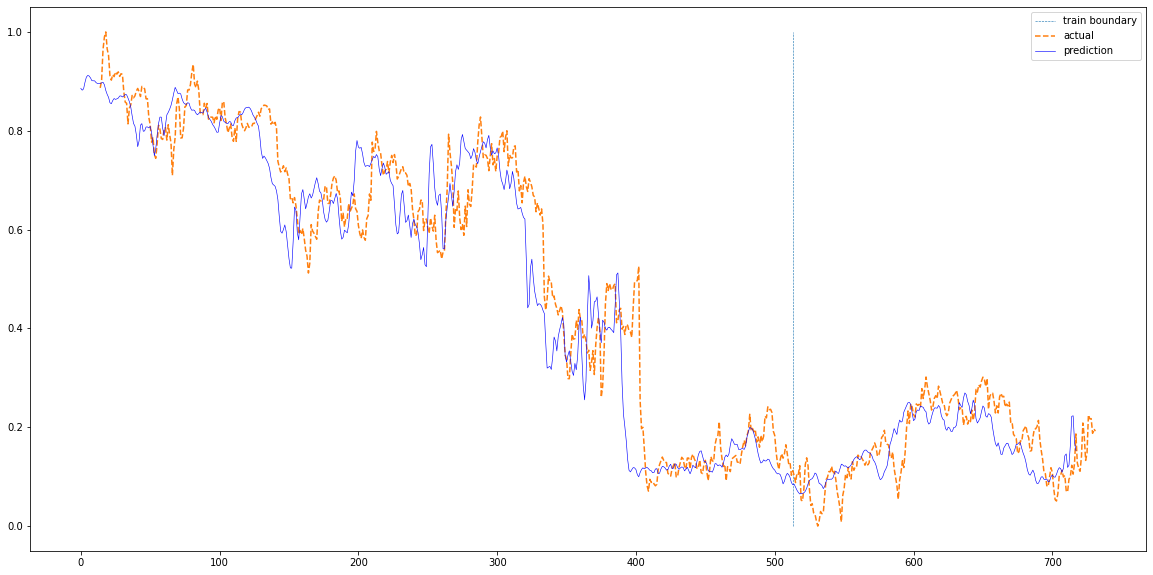

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

df = pd.read_csv('/gdrive/MyDrive/stock/stock.csv',sep=',')

print(df.head())
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Close']]) # 최대최소 정규화를 진행해준다.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# 데이터 셋을 target 기준으로 분리시킨다
x = df[['Open','High','Low','Volume']].values 
y = df['Close'].values

# x는 2주치씩 끊어주고, y는 15일차의 데이터를 저장하도록 데이터를 쪼개주는 함수.
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.

# 70% 는 약 513개 데이터 (513기준 앞부분은 훈련대상이 되는 데이터, 뒷부분은 테스트 대상이 되는 데이터)
split = 513
# 2주 =14일
sequence_length = 14


x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

# 훈련, 테스트하기 편한 batch 형태로 만들기
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#  입력노드 수를 정하고, 레이어의 개수 정하고, hidden state의 크기도 정함
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 10 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])

#https://data-science-hi.tistory.com/190